In [256]:
import sys
sys.path.append('../10_utils/')
import colorDict

age_color_dict = colorDict.age_color_dict()
tissue_color_dict = colorDict.tissue_color_dict()

In [257]:
tissue_color_dict

{'Bladder': '#393b79',
 'Brain_Myeloid': '#393b79',
 'Brain_Non-Myeloid': '#5254a3',
 'Fat': '#6b6ecf',
 'Heart_and_Aorta': '#9c9ede',
 'Kidney': '#637939',
 'Large_Intestine': '#8ca252',
 'Limb_Muscle': '#b5cf6b',
 'Liver': '#cedb9c',
 'Lung': '#8c6d31',
 'Mammary_Gland': '#bd9e39',
 'Marrow': '#e7ba52',
 'Pancreas': '#e7ba52',
 'Skin': '#e7cb94',
 'Spleen': '#843c39',
 'Thymus': '#ad494a',
 'Tongue': '#d6616b',
 'Trachea': '#e7969c',
 'BAT': '#7b4173',
 'GAT': '#a55194',
 'MAT': '#ce6dbd',
 'SCAT': '#de9ed6'}

In [1]:
import sys
sys.path.append('../../../../src/scVI/')
import scvi
from scvi.inference import UnsupervisedTrainer, AlternateSemiSupervisedTrainer
from scvi.models import VAE, SCANVI
from scvi.dataset.anndataset import AnnDatasetFromAnnData

[2020-01-11 11:49:44,343] INFO - scvi._settings | Added StreamHandler with custom formatter to 'scvi' logger.
/home/angela/anaconda3/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:21: DeprecationWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


In [2]:
scvi.__version__ 

'0.5.0'

In [81]:
import torch
import numpy as np

torch.manual_seed(0)
np.random.seed(0)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scanpy as sc

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()

scanpy==1.4.2 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.2 scipy==1.3.1 pandas==0.25.1 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1 


In [4]:
torch.cuda.is_available()

True

In [5]:
import scvi
from scvi.dataset import AnnDatasetFromAnnData
from scvi.inference import UnsupervisedTrainer
from scvi.models.vae import VAE
from typing import Tuple

In [6]:
from scvi.dataset import AnnDatasetFromAnnData

In [7]:
pwd

'/home/angela/maca/tabula-muris-senis/1_tabula_muris_senis/11_figure_1'

In [8]:
adata_droplet = sc.read_h5ad('../../0_data_ingest/01_figure_1/tabula-muris-senis-droplet-official-raw-obj.h5ad')
display(adata_droplet)

AnnData object with n_obs × n_vars = 245389 × 20138 
    obs: 'age', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation'
    var: 'n_cells'

In [234]:
adata_droplet#.obs['cell_ontology_class'] = adata_droplet.obs['cell_ontology_class_reannotated']

AnnData object with n_obs × n_vars = 245389 × 20138 
    obs: 'age', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation'
    var: 'n_cells'

In [242]:
adata_droplet_small = adata_droplet[adata_droplet.obs['cell_ontology_class']=='hepatocyte'].copy()
adata_droplet_small = adata_droplet_small[adata_droplet_small.obs['age'].isin(['30m','3m'])].copy()
adata_droplet_small

AnnData object with n_obs × n_vars = 1019 × 20138 
    obs: 'age', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation'
    var: 'n_cells'

In [251]:
adata#.obsm['X_umap'].shape#_droplet_small.obsm

AnnData object with n_obs × n_vars = 356213 × 20116 
    obs: 'age', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_counts', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation', 'louvain_scvi', 'tint', 'age_group'
    var: 'n_cells-0', 'n_cells-1'
    uns: 'pca', 'neighbors', 'louvain', 'tissue_colors', 'rank_genes_groups_scvi', 'rank_genes_groups_wilcox'
    obsm: 'X_scvi', 'X_pca', 'X_umap'
    varm: 'PCs'

In [10]:
# adata_droplet.obs = adata_droplet.obs.drop(
#     ['batch', 'cell', 'cell_ontology_class_reannotated', 'n_genes','tissue_free_annotation'],axis=1)
# adata_droplet

In [11]:
adata_facs = sc.read_h5ad('../../0_data_ingest/01_figure_1/tabula-muris-senis-facs-official-raw-obj.h5ad')
display(adata_facs)

AnnData object with n_obs × n_vars = 110824 × 22966 
    obs: 'FACS.selection', 'age', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'sex', 'subtissue', 'tissue', 'n_genes', 'n_counts'
    var: 'n_cells'

In [12]:
adata_facs.obs = adata_facs.obs.drop(['FACS.selection','cell'],axis=1)
adata_facs

AnnData object with n_obs × n_vars = 110824 × 22966 
    obs: 'age', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'sex', 'subtissue', 'tissue', 'n_genes', 'n_counts'
    var: 'n_cells'

In [13]:
adata = adata_droplet.concatenate(adata_facs)

In [14]:
sum(adata.obs.batch=='0'),sum(adata.obs.batch=='1')

(245389, 110824)

In [18]:
import scvi
from scvi.dataset import AnnDatasetFromAnnData
from scvi.inference import UnsupervisedTrainer
from scvi.models.vae import VAE
from typing import Tuple


def compute_scvi_latent(
    adata: sc.AnnData,
    n_latent: int = 10,
    n_epochs: int = 100,
    lr: float = 1e-3,
    use_batches: bool = False,
    use_cuda: bool = False,
) -> Tuple[scvi.inference.Posterior, np.ndarray]:
    """Train and return a scVI model and sample a latent space
    
    :param adata: sc.AnnData object non-normalized
    :param n_latent: dimension of the latent space
    :param n_epochs: number of training epochs
    :param lr: learning rate
    :param use_batches
    :param use_cuda
    :return: (scvi.Posterior, latent_space)
    """
    # Convert easily to scvi dataset
    scviDataset = AnnDatasetFromAnnData(adata,batch_label = 'batch')

    # Train a model
    vae = VAE(
        scviDataset.nb_genes,
        n_batch=scviDataset.n_batches * use_batches,
        n_hidden=128, n_latent=30, n_layers=5, dispersion='gene'
    )
    trainer = UnsupervisedTrainer(vae, scviDataset, train_size=.99, use_cuda=use_cuda)
    trainer.train(n_epochs=n_epochs, lr=lr)
    ####
    
    torch.save(trainer.model.state_dict(), 'tms-scVI-trainer-model')

    # Extract latent space
    posterior = trainer.create_posterior(
        trainer.model, scviDataset, indices=np.arange(len(scviDataset))
    ).sequential()

    latent, _, _ = posterior.get_latent()

    return posterior, latent


In [19]:
adata

AnnData object with n_obs × n_vars = 356213 × 20116 
    obs: 'age', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_counts', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation'
    var: 'n_cells-0', 'n_cells-1'

In [20]:
n_epochs_all = None
n_epochs = 100 if n_epochs_all is None else n_epochs_all

scvi_posterior, scvi_latent = compute_scvi_latent(
    adata, n_epochs=n_epochs, n_latent=6,
    use_batches = True, use_cuda=True
)
adata.obsm["X_scvi"] = scvi_latent

[2020-01-11 11:50:34,967] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-01-11 11:50:34,978] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-01-11 11:50:38,110] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-01-11 11:50:41,200] INFO - scvi.dataset.dataset | Downsampled from 356213 to 356213 cells


training: 100%|██████████| 100/100 [1:57:05<00:00, 70.25s/it]


In [23]:
adata.write('tms-scVI-adata.h5ad')

... storing 'age' as categorical
... storing 'cell' as categorical
... storing 'cell_ontology_class' as categorical
... storing 'cell_ontology_id' as categorical
... storing 'free_annotation' as categorical
... storing 'method' as categorical
... storing 'mouse.id' as categorical
... storing 'subtissue' as categorical
... storing 'tissue' as categorical
... storing 'tissue_free_annotation' as categorical


In [ ]:
trainer = UnsupervisedTrainer(vae, scviDataset, train_size=.99, use_cuda=use_cuda)
trainer.model.load_state_dict(torch.load('tms-scVI-trainer-model'))

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import scanpy.api as sc
from igraph import *
from MulticoreTSNE import MulticoreTSNE as TSNE #faster TSNE alternative
from anndata import read_h5ad
from anndata import read_csv

sc.settings.verbosity = 3
sc.logging.print_versions()
np.random.seed(685)

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.set_figure_params(dpi=50)

In [ ]:
# adata = read_h5ad('../../0_data_ingest/01_figure_1/tabula-muris-senis-scVI-official-annotations-umap.h5ad')
adata = read_h5ad('../../../tabula-muris-senis-scVI-official-annotations.h5ad')
adata

computing PCA with n_comps = 50
    finished (0:02:23.92)


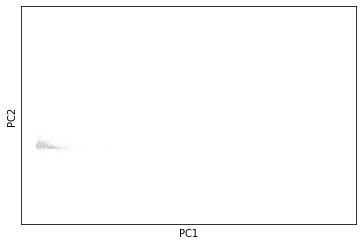

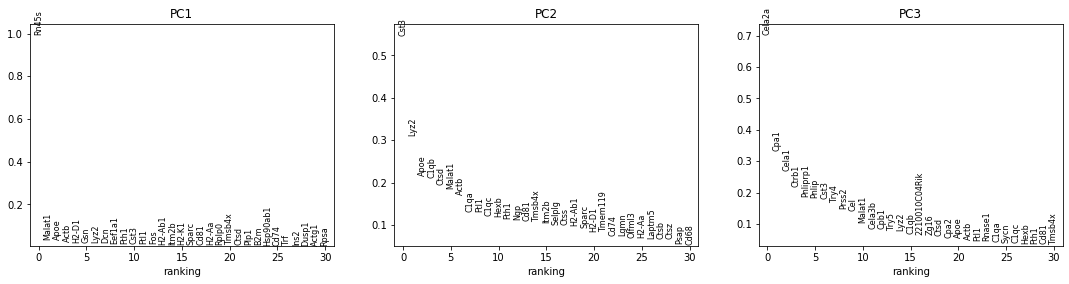

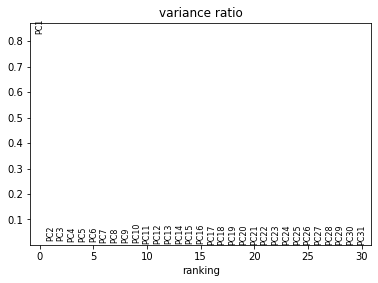

In [24]:
sc.tl.pca(adata, svd_solver="arpack")
sc.pl.pca_overview(adata)

In [25]:
sc.pp.neighbors(adata, n_neighbors=20, n_pcs=40, use_rep="X_scvi")
sc.tl.umap(adata)

computing neighbors


/home/angela/anaconda3/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../anaconda3/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  self.func_ir.loc))
/home/angela/anaconda3/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../anaconda3/lib/python3.7/site-packages/umap/utils.py"

    finished (0:01:30.07) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:08:26.68) --> added
    'X_umap', UMAP coordinates (adata.obsm)


In [26]:
sc.tl.louvain(adata, key_added="louvain_scvi", resolution=0.7)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:04:02.23) --> found 50 clusters and added
    'louvain_scvi', the cluster labels (adata.obs, categorical)


In [27]:
adata.obs[adata.obs['cell_ontology_class']=='B cell']

,age,batch,cell,cell_ontology_class,cell_ontology_id,free_annotation,method,mouse.id,n_counts,n_genes,sex,subtissue,tissue,tissue_free_annotation,louvain_scvi
AAACGGGGTAAGTTCC-1-4-0-0-0,18m,0,MACA_18m_F_BREAST_50_AAACGGGGTAAGTTCC,B cell,NA,B cell,droplet,18-F-50,NaN,1966.0,female,nan,Mammary_Gland,Mammary_Gland,35
AAACGGGTCGAATGGG-1-4-0-0-0,18m,0,MACA_18m_F_BREAST_50_AAACGGGTCGAATGGG,B cell,NA,B cell,droplet,18-F-50,NaN,1252.0,female,nan,Mammary_Gland,Mammary_Gland,43
AACTCAGCAGGTCCAC-1-4-0-0-0,18m,0,MACA_18m_F_BREAST_50_AACTCAGCAGGTCCAC,B cell,NA,B cell,droplet,18-F-50,NaN,1056.0,female,nan,Mammary_Gland,Mammary_Gland,10
AAGTCTGGTTCGTGAT-1-4-0-0-0,18m,0,MACA_18m_F_BREAST_50_AAGTCTGGTTCGTGAT,B cell,NA,B cell,droplet,18-F-50,NaN,1018.0,female,nan,Mammary_Gland,Mammary_Gland,35
ACGATGTGTAAGGATT-1-4-0-0-0,18m,0,MACA_18m_F_BREAST_50_ACGATGTGTAAGGATT,B cell,NA,B cell,droplet,18-F-50,NaN,1331.0,female,nan,Mammary_Gland,Mammary_Gland,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P9.MAA000531.3_8_M.1.1-1-1-1,3m,1,nan,B cell,CL:0000236,nan,facs,3_8_M,231316.0,1489.0,male,Fat,MAT,nan,0
P9.MAA000559.3_8_M.1.1-1-1-1,3m,1,nan,B cell,CL:0000236,CD79a B cell,facs,3_8_M,410087.0,1780.0,male,nan,Spleen,nan,0
P9.MAA000877.3_11_M.1.1-1-1-1,3m,1,nan,B cell,CL:0000236,nan,facs,3_11_M,608430.0,2375.0,male,Fat,MAT,nan,8
P9.MAA000914.3_9_M.1.1-1-1-1,3m,1,nan,B cell,CL:0000236,nan,facs,3_9_M,338307.0,1330.0,male,Fat,MAT,nan,35


In [254]:
tissue_color_dict

{'Bladder': '#393b79',
 'Brain_Myeloid': '#393b79',
 'Brain_Non-Myeloid': '#5254a3',
 'Fat': '#6b6ecf',
 'Heart_and_Aorta': '#9c9ede',
 'Kidney': '#637939',
 'Large_Intestine': '#8ca252',
 'Limb_Muscle': '#b5cf6b',
 'Liver': '#cedb9c',
 'Lung': '#8c6d31',
 'Mammary_Gland': '#bd9e39',
 'Marrow': '#e7ba52',
 'Pancreas': '#e7ba52',
 'Skin': '#e7cb94',
 'Spleen': '#843c39',
 'Thymus': '#ad494a',
 'Tongue': '#d6616b',
 'Trachea': '#e7969c',
 'BAT': '#7b4173',
 'GAT': '#a55194',
 'MAT': '#ce6dbd',
 'SCAT': '#de9ed6'}

In [255]:
set(adata.obs['tissue'])

{'Aorta',
 'BAT',
 'Bladder',
 'Brain_Myeloid',
 'Brain_Non-Myeloid',
 'Diaphragm',
 'Fat',
 'GAT',
 'Heart',
 'Heart_and_Aorta',
 'Kidney',
 'Large_Intestine',
 'Limb_Muscle',
 'Liver',
 'Lung',
 'MAT',
 'Mammary_Gland',
 'Marrow',
 'Pancreas',
 'SCAT',
 'Skin',
 'Spleen',
 'Thymus',
 'Tongue',
 'Trachea'}

In [252]:
adata_nonans.uns['tissue_colors'] = list(maca_color_dict.values())

AnnData object with n_obs × n_vars = 356213 × 20116 
    obs: 'age', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_counts', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation', 'louvain_scvi', 'tint', 'age_group'
    var: 'n_cells-0', 'n_cells-1'
    uns: 'pca', 'neighbors', 'louvain', 'tissue_colors', 'rank_genes_groups_scvi', 'rank_genes_groups_wilcox'
    obsm: 'X_scvi', 'X_pca', 'X_umap'
    varm: 'PCs'

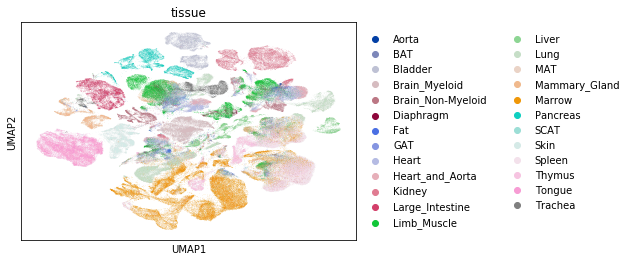

In [35]:
sc.pl.umap(adata,color='tissue')

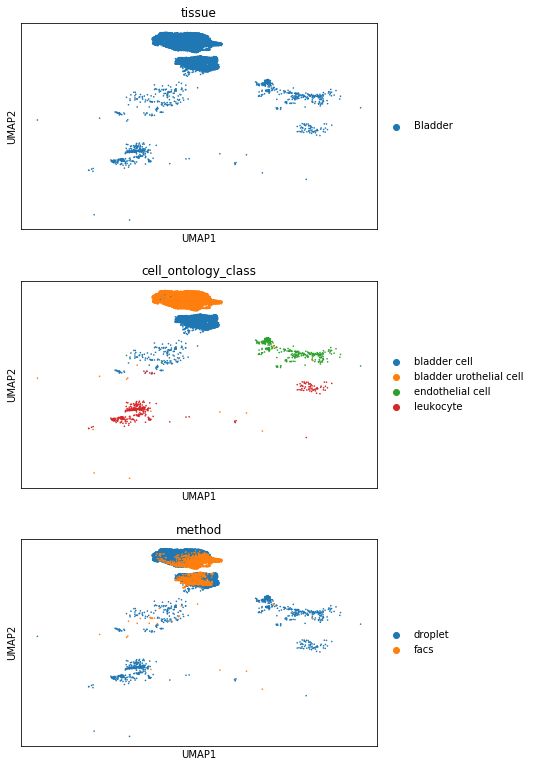

In [34]:
sc.pl.umap(adata[adata.obs['tissue'].isin(['Bladder'])],
           color=['tissue','cell_ontology_class','method'],
          ncols=1)

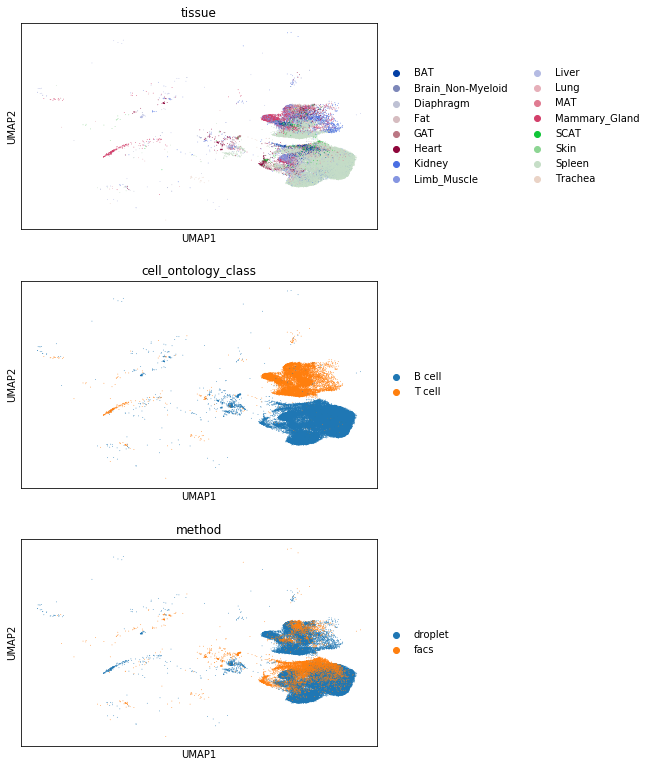

In [31]:
sc.pl.umap(adata[adata.obs['cell_ontology_class'].isin(['B cell','T cell'])],
           color=['tissue','cell_ontology_class','method'],
          ncols=1)

In [ ]:
sc.pl.umap(adata, color=['age'], ncols=1, save = '_tms_age.pdf')
sc.pl.umap(adata, color=['tissue'], ncols=1, save = '_tms_tissue.pdf')
sc.pl.umap(adata, color=['method'], ncols=1, save = '_tms_method.pdf')

In [105]:
adata

AnnData object with n_obs × n_vars = 356213 × 20116 
    obs: 'age', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_counts', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation', 'louvain_scvi', 'tint'
    var: 'n_cells-0', 'n_cells-1'
    uns: 'pca', 'neighbors', 'louvain', 'tissue_colors', 'rank_genes_groups_scvi', 'rank_genes_groups_wilcox'
    obsm: 'X_scvi', 'X_pca', 'X_umap'
    varm: 'PCs'

In [107]:
adatanorm = adata.copy()
adatanorm.raw = adatanorm

sc.pp.normalize_per_cell(adatanorm, counts_per_cell_after=1e4)
sc.pp.log1p(adatanorm)

adatanorm.write('tms-scVI-adata-normalized.h5ad')

In [106]:
senescence_adata.write('tms-scVI-adata-normalized.h5ad')

AnnData object with n_obs × n_vars = 356213 × 20116 
    obs: 'age', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_counts', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation', 'louvain_scvi', 'tint'
    var: 'n_cells-0', 'n_cells-1'
    uns: 'pca', 'neighbors', 'louvain', 'tissue_colors', 'rank_genes_groups_scvi', 'rank_genes_groups_wilcox'
    obsm: 'X_scvi', 'X_pca', 'X_umap'
    varm: 'PCs'

In [36]:
def rank_genes_groups_bayes(
    adata: sc.AnnData,
    scvi_posterior: scvi.inference.Posterior,
    use_observed_batches: bool = True,
    n_samples: int = None,
    M_permutation: int = None,
    n_genes: int = 25,
    label_name: str = "louvain_scvi",
) -> pd.DataFrame:
    """
    Rank genes for characterizing groups. 
    Computes Bayes factor for each cluster against the others to test for differential expression.
    See Nature article (https://rdcu.be/bdHYQ)

    :param adata: sc.AnnData object non-normalized
    :param scvi_posterior: 
    :param n_samples: 
    :param M_permutation: 
    :param n_genes: 
    :param label_name: The groups tested are taken from adata.obs[label_name] which can be computed 
                       using clustering like Louvain (Ex: sc.tl.louvain(adata, key_added=label_name) )
    :return: Summary of Bayes factor per gene, per cluster
    """

    # Call scvi function
    per_cluster_de, cluster_id = scvi_posterior.one_vs_all_degenes(
        cell_labels=np.asarray(adata.obs[label_name].values).astype(int).ravel(),
        min_cells=1,
        n_samples=n_samples,
        M_permutation=M_permutation
    )

    # convert to ScanPy format -- this is just about feeding scvi results into a format readable by ScanPy
    markers = []
    scores = []
    names = []
    for i, x in enumerate(per_cluster_de):
        subset_de = x[:n_genes]
        markers.append(subset_de)
        scores.append(tuple(subset_de["bayes1"].values))
        names.append(tuple(subset_de.index.values))

    markers = pd.concat(markers)
    dtypes_scores = [(str(i), "<f4") for i in range(len(scores))]
    dtypes_names = [(str(i), "<U50") for i in range(len(names))]
    scores = np.array([tuple(row) for row in np.array(scores).T], dtype=dtypes_scores)
    scores = scores.view(np.recarray)
    names = np.array([tuple(row) for row in np.array(names).T], dtype=dtypes_names)
    names = names.view(np.recarray)

    adata.uns["rank_genes_groups_scvi"] = {
        "params": {
            "groupby": "",
            "reference": "rest",
            "method": "",
            "use_raw": True,
            "corr_method": "",
        },
        "scores": scores,
        "names": names,
    }
    return markers

In [ ]:
adata

In [ ]:
set(adata.obs['agenum'])

In [40]:
tissuelist = list(set(adata.obs['tissue']))
tissuelist.sort()
tissuelist

['Aorta',
 'BAT',
 'Bladder',
 'Brain_Myeloid',
 'Brain_Non-Myeloid',
 'Diaphragm',
 'Fat',
 'GAT',
 'Heart',
 'Heart_and_Aorta',
 'Kidney',
 'Large_Intestine',
 'Limb_Muscle',
 'Liver',
 'Lung',
 'MAT',
 'Mammary_Gland',
 'Marrow',
 'Pancreas',
 'SCAT',
 'Skin',
 'Spleen',
 'Thymus',
 'Tongue',
 'Trachea']

In [195]:
adata.obs['age_group'] = 0
adata.obs.loc[adata.obs['age'].isin(['1m','3m']),'age_group'] = 0
adata.obs.loc[adata.obs['age'].isin(['18m','21m','24m','30m']),'age_group'] = 1

adata.obs

,age,batch,cell,cell_ontology_class,cell_ontology_id,free_annotation,method,mouse.id,n_counts,n_genes,sex,subtissue,tissue,tissue_free_annotation,louvain_scvi,tint,age_group
AAACCTGCAGGGTACA-1-0-0-0-0,24m,0,MACA_24m_M_TONGUE_60_AAACCTGCAGGGTACA,keratinocyte,NA,filiform,droplet,24-M-60,NaN,2107.0,male,nan,Tongue,Tongue,1,23,1
AAACCTGCAGTAAGCG-1-0-0-0-0,24m,0,MACA_24m_M_TONGUE_60_AAACCTGCAGTAAGCG,keratinocyte,NA,suprabasal,droplet,24-M-60,NaN,3481.0,male,nan,Tongue,Tongue,1,23,1
AAACCTGTCATTATCC-1-0-0-0-0,24m,0,MACA_24m_M_TONGUE_60_AAACCTGTCATTATCC,keratinocyte,NA,suprabasal,droplet,24-M-60,NaN,2599.0,male,nan,Tongue,Tongue,1,23,1
AAACGGGGTACAGTGG-1-0-0-0-0,24m,0,MACA_24m_M_TONGUE_60_AAACGGGGTACAGTGG,keratinocyte,NA,suprabasal differentiating,droplet,24-M-60,NaN,3468.0,male,nan,Tongue,Tongue,1,23,1
AAACGGGGTCTTCTCG-1-0-0-0-0,24m,0,MACA_24m_M_TONGUE_60_AAACGGGGTCTTCTCG,keratinocyte,NA,suprabasal differentiating,droplet,24-M-60,NaN,3189.0,male,nan,Tongue,Tongue,1,23,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P8_MAA001690_S20.mus-2-1-1,21m,1,nan,basal cell,NA,basal cell,facs,21_54_F,146922.0,3523.0,female,Mammary_Gland,Mammary_Gland,nan,32,16,1
P8_MAA001700_S104.mus-2-1-1,21m,1,nan,basal cell,NA,basal cell,facs,21_55_F,1027535.0,4476.0,female,Mammary_Gland,Mammary_Gland,nan,32,16,1
P9_B000485_S69.mus-2-1-1,18m,1,nan,basal cell,NA,basal cell,facs,18_47_F,1184061.0,2980.0,female,Mammary_Gland,Mammary_Gland,nan,32,16,1
P9_B000492_S153.mus-2-1-1,18m,1,nan,basal cell,NA,basal cell,facs,18_46_F,771128.0,2595.0,female,Mammary_Gland,Mammary_Gland,nan,32,16,1


In [198]:
adata.obs.tail()

,age,batch,cell,cell_ontology_class,cell_ontology_id,free_annotation,method,mouse.id,n_counts,n_genes,sex,subtissue,tissue,tissue_free_annotation,louvain_scvi,tint,age_group
P8_MAA001690_S20.mus-2-1-1,21m,1,nan,basal cell,NA,basal cell,facs,21_54_F,146922.0,3523.0,female,Mammary_Gland,Mammary_Gland,nan,32,16,1
P8_MAA001700_S104.mus-2-1-1,21m,1,nan,basal cell,NA,basal cell,facs,21_55_F,1027535.0,4476.0,female,Mammary_Gland,Mammary_Gland,nan,32,16,1
P9_B000485_S69.mus-2-1-1,18m,1,nan,basal cell,NA,basal cell,facs,18_47_F,1184061.0,2980.0,female,Mammary_Gland,Mammary_Gland,nan,32,16,1
P9_B000492_S153.mus-2-1-1,18m,1,nan,basal cell,NA,basal cell,facs,18_46_F,771128.0,2595.0,female,Mammary_Gland,Mammary_Gland,nan,32,16,1
P9_MAA001700_S105.mus-2-1-1,21m,1,nan,basal cell,NA,basal cell,facs,21_55_F,31365.0,2520.0,female,Mammary_Gland,Mammary_Gland,nan,32,16,1


In [ ]:
import xlsxwriter
adata.obs['louvain'] = adata.obs['louvain'].astype(int)
adata.obs['tissue'] = adata.obs['tissue'].astype(str)
adata.obs['mouse.id'] = adata.obs['mouse.id'].astype(str)
adata.obs['age'] = adata.obs['age'].astype(str)
adata.obs['sex'] = adata.obs['sex'].astype(str)
adata.obs['cell_ontology_class_reannotated'] = adata.obs['cell_ontology_class_reannotated'].astype(str)

# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('maca-droplet-summary.xlsx', engine='xlsxwriter')


df = adata.obs.groupby(['age','sex','mouse.id','tissue'])['age'].agg({'# cells':len})
df.to_excel(writer, sheet_name='droplet-summary')

df = adata.obs.groupby(['tissue','cell_ontology_class_reannotated','age'])['age'].agg({'# cells':len})
df.to_excel(writer, sheet_name='droplet-cell-type-summary')


df = adata.obs.groupby(['louvain','cell_ontology_class_reannotated','tissue','age'])['age'].agg({'# cells':len})
df.to_excel(writer, sheet_name='cluster-cell-type-tissue-age')

df = adata.obs.groupby(['cell_ontology_class_reannotated','louvain','tissue','age'])['age'].agg({'# cells':len})
df.to_excel(writer, sheet_name='cell-type-cluster-tissue-age')


df = adata.obs.groupby(['cell_ontology_class_reannotated','tissue','louvain'])['age'].agg({'len':len})
df = df.unstack('louvain')
df.columns = df.columns.droplevel(0)
df[df.columns] = df[df.columns].apply(pd.to_numeric)#, errors='coerce')
df['sum'] = df.sum(axis=1)
df = df.loc[:, df.columns].div(df['sum'], axis=0)*100
df = df.drop('sum',axis=1)
df = df.round(2)
df = df.replace(np.nan,' ')
df.to_excel(writer, sheet_name='cell-type_tissue_louvain-number')

df = adata.obs.groupby(['louvain','tissue'])['age'].agg({'len':len})
df = df.unstack('tissue')
df.columns = df.columns.droplevel(0)
df[df.columns] = df[df.columns].apply(pd.to_numeric)#, errors='coerce')
df['sum'] = df.sum(axis=1)
df = df.loc[:, df.columns].div(df['sum'], axis=0)*100
df = df.drop('sum',axis=1)
df = df.round(2)
df = df.replace(np.nan,' ')
df.to_excel(writer, sheet_name='tissue_louvain-number')

df = adata.obs.groupby(['louvain','cell_ontology_class_reannotated'])['age'].agg({'len':len})
df = df.unstack('cell_ontology_class_reannotated')
df.columns = df.columns.droplevel(0)
df[df.columns] = df[df.columns].apply(pd.to_numeric)#, errors='coerce')
df['sum'] = df.sum(axis=1)
df = df.loc[:, df.columns].div(df['sum'], axis=0)*100
df = df.drop('sum',axis=1)
df = df.round(2)
df = df.replace(np.nan,' ')
df.to_excel(writer, sheet_name='louvain-number_cell-type')


# Close the Pandas Excel writer and output the Excel file.
writer.save()


In [217]:
scviDataset.n_batches

2

[2020-01-14 15:25:13,055] INFO - scvi.dataset.anndataset | Dense size under 1Gb, casting to dense format (np.ndarray).
[2020-01-14 15:25:14,160] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-01-14 15:25:14,162] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-01-14 15:25:14,750] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-01-14 15:25:15,217] INFO - scvi.dataset.dataset | Downsampled from 11377 to 11377 cells


In [226]:
all_genes = len(adata.var_names)

use_batches = True
use_cuda = True

for t in ['Bladder']:#list(set(adata.obs['tissue'])):
    tiss = adata.copy()
    tiss = tiss[tiss.obs['tissue']==t].copy()
    istiss = np.where(adata.obs['tissue']==t)[0]
    
    scviDataset = AnnDatasetFromAnnData(tiss,batch_label = 'batch')
    # Train a model
    vae = VAE(
        scviDataset.nb_genes,
        n_batch=scviDataset.n_batches * use_batches,
        n_hidden=128, n_latent=30, n_layers=5, dispersion='gene'
    )
    tiss_trainer = UnsupervisedTrainer(vae, scviDataset, train_size=.99, use_cuda=use_cuda)

    tiss_posterior = tiss_trainer.create_posterior(scvi_posterior.model, scviDataset, indices=np.arange(len(tiss))).sequential()


    rank_genes_groups_bayes(
        tiss, tiss_posterior, label_name="age_group", n_genes=all_genes
    )
    
    result = tiss.uns['rank_genes_groups_scvi']
    groups = result['names'].dtype.names
    dge = pd.DataFrame(
        {group + '_' + key[:1]: result[key][group]
        for group in groups for key in ['names', 'scores']})
    

[2020-01-14 15:29:53,961] INFO - scvi.dataset.anndataset | Dense size under 1Gb, casting to dense format (np.ndarray).
[2020-01-14 15:29:55,071] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-01-14 15:29:55,073] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-01-14 15:29:55,512] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-01-14 15:29:55,945] INFO - scvi.dataset.dataset | Downsampled from 11377 to 11377 cells


In [233]:
tiss_posterior.gene_dataset

GeneExpressionDataset object with n_cells x nb_genes = 11377 x 20116
    dataset_versions: 'norm_X'
    gene_attribute_names: 'gene_names'
    cell_attribute_names: 'local_vars', 'local_means', 'batch_indices', 'labels'
    cell_categorical_attribute_names: 'batch_indices', 'labels'

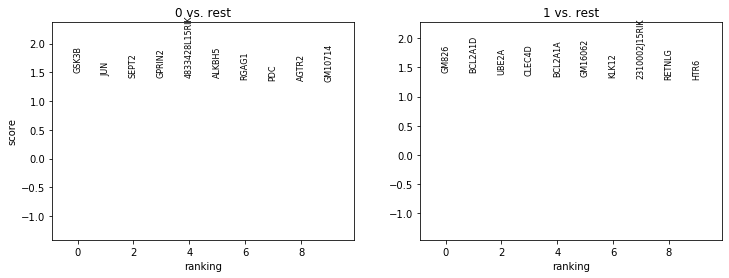

In [224]:
sc.pl.rank_genes_groups(
    tiss, key="rank_genes_groups_scvi", sharey=False, n_genes=n_genes)

In [64]:
adata

AnnData object with n_obs × n_vars = 356213 × 20116 
    obs: 'age', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_counts', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation', 'louvain_scvi', 'tint'
    var: 'n_cells-0', 'n_cells-1'
    uns: 'pca', 'neighbors', 'louvain', 'tissue_colors', 'rank_genes_groups_scvi', 'rank_genes_groups_wilcox'
    obsm: 'X_scvi', 'X_pca', 'X_umap'
    varm: 'PCs'

In [66]:
adata

AnnData object with n_obs × n_vars = 356213 × 20116 
    obs: 'age', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_counts', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation', 'louvain_scvi', 'tint'
    var: 'n_cells-0', 'n_cells-1'
    uns: 'pca', 'neighbors', 'louvain', 'tissue_colors', 'rank_genes_groups_scvi', 'rank_genes_groups_wilcox'
    obsm: 'X_scvi', 'X_pca', 'X_umap'
    varm: 'PCs'

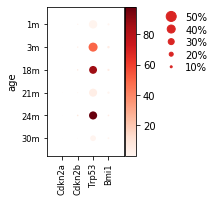

GridSpec(2, 5, height_ratios=[0, 10.5], width_ratios=[1.4, 0, 0.2, 0.5, 0.25])

In [72]:
sc.pl.dotplot(adata,['Cdkn2a','Cdkn2b','Trp53','Bmi1'],groupby='age')

In [103]:
np.unique(adata[:,sm].X)

/home/angela/anaconda3/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


array([0.0000e+00, 1.0000e+00, 2.0000e+00, ..., 3.7537e+04, 5.0697e+04,
       8.1945e+04], dtype=float32)

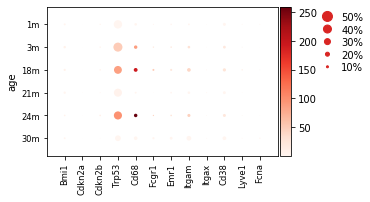

GridSpec(2, 5, height_ratios=[0, 10.5], width_ratios=[4.199999999999999, 0, 0.2, 0.5, 0.25])

In [108]:
sc.pl.dotplot(adata, senescence_markers, groupby='age')

In [154]:
senescence_markers = ['Bmi1','Cdkn2a','Cdkn2b','Trp53',
                      'Cd68','Fcgr1','Emr1','Itgam',
                      'Itgax','Cd38','Lyve1','Fcna']
senescence = adata.obs.copy()
# senescence_adata = adata.copy()
# sc.pp.normalize_per_cell(senescence_adata, counts_per_cell_after=1e4)
# sc.pp.log1p(senescence_adata)

senescence_fractions = pd.DataFrame()

for sm in senescence_markers:
    
    senescence[sm] = senescence_adata[:,sm].X#.todense()
    senescence[sm + '_exp'] = senescence[sm].replace(0.0,np.nan)

#     dfexp = senescence.groupby(['age','tissue','mouse.id'])[sm+'_exp'].agg({'mean':np.nanmedian})
    dfexp = senescence.groupby(['age','tissue'])[sm+'_exp'].agg({'mean':np.nanmedian})
    senescence[sm] = senescence[sm].astype(bool)
    dfexp = dfexp.reset_index()
#     df = senescence.groupby(['age','tissue','mouse.id'])[sm].agg({'sum':np.sum,'len':len})
    df = senescence.groupby(['age','tissue'])[sm].agg({'sum':np.sum,'len':len})
#     df = df.reset_index()
    df['frac'] = df['sum']/df['len']
    df['mean'] = np.log(dfexp['mean'])
    
    if senescence_fractions.empty:
        senescence_fractions = pd.DataFrame(index=df.index)
    
    senescence_fractions[sm] = df['frac']

#     plt.figure()
# #     fig, ax1 = plt.subplots(1)
#     fig, (ax1, ax2) = plt.subplots(1, 2)
#     sns.boxplot(x='age', y='frac', data=df, hue = 'method',
#                 order=['1m','3m','18m','21m','24m','30m'], 
# #                 palette=age_color_dict, 
#                 ax= ax1
#                )
# #     sns.swarmplot(x='age', y='frac', data=df, hue = 'method',
# #                   order=['1m','3m','18m','21m','24m','30m'], ax= ax1, color=".25")
#     ax1.set(xlabel='', ylabel='Fraction of '+ sm + '+ cells')
    
#     sns.boxplot(x='age', y='mean', data=df, hue = 'method',
#                 order=['1m','3m','18m','21m','24m','30m'], 
# #                 palette=age_color_dict, 
#                 ax= ax2)
# #     sns.swarmplot(x='age', y='mean', data=df, hue = 'method',
# #                   order=['1m','3m','18m','21m','24m','30m'], color=".25", ax= ax2)
#     ax2.set(xlabel='', ylabel= sm + ' median expression in ' + sm + '+ cells')
#     plt.tight_layout()

/home/angela/anaconda3/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()
/home/angela/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

/home/angela/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future v

In [183]:
# senescence_markers = ['Bmi1','Cdkn2a','Cdkn2b','Trp53',
#                       'Cd68','Fcgr1','Emr1','Itgam',
#                       'Itgax','Cd38','Lyve1','Fcna']

# genesofinterest = ['Cdkn2a','Cdkn1a','Bcl2l2','Nfkb1','Lmnb1','Ccl2','Csf1','Serpine1','Hmgb1','Tnf',
#                    'Il6','Il12a','Il12b','Il10','Il1b','Il18','Nfkbiz','Irg1','Arg1','Retnla','Mrc1',
#                    'Mgl2','Cd36','Fabp4','Cd38','Bst1','Sirt1','Sirt2','Sirt3','Sirt4','Sirt5','Sirt6',
#                    'Sirt7','Parp1','Parp2','Parp3','Parp4','Tnks','Parp6','Tiparp','Parp8','Parp9',
#                    'Parp10','Parp11','Parp12','Zc3hav1','Parp14','Parp16','Sarm1','Nampt','Nadk',
#                    'Nt5e','Nmnat1','Nmnat2','Nmnat3','Nnmt']

# senescence_markers = list(set(senescence_markers + genesofinterest))

len(senescence_markers)

66

In [180]:
senescence_markers = ['Bmi1','Cdkn2a','Cdkn2b','Trp53',
                      'Cd68','Fcgr1','Emr1','Itgam',
                      'Itgax','Cd38','Lyve1','Fcna']

genesofinterest = ['Cdkn2a','Cdkn1a','Bcl2l2','Nfkb1','Lmnb1','Ccl2','Csf1','Serpine1','Hmgb1','Tnf',
                   'Il6','Il12a','Il12b','Il10','Il1b','Il18','Nfkbiz','Irg1','Arg1','Retnla','Mrc1',
                   'Mgl2','Cd36','Fabp4','Cd38','Bst1','Sirt1','Sirt2','Sirt3','Sirt4','Sirt5','Sirt6',
                   'Sirt7','Parp1','Parp2','Parp3','Parp4','Tnks','Parp6','Tiparp','Parp8','Parp9',
                   'Parp10','Parp11','Parp12','Zc3hav1','Parp14','Parp16','Sarm1','Nampt','Nadk',
                   'Nt5e','Nmnat1','Nmnat2','Nmnat3','Nnmt']

senescence_markers = list(set(senescence_markers + genesofinterest))

senescence = adata.obs.copy()

senescence_fractions = pd.DataFrame()

for sm in senescence_markers:
    
    senescence[sm] = senescence_adata[:,sm].X#.todense()
    senescence[sm + '_exp'] = senescence[sm].replace(0.0,np.nan)

#     dfexp = senescence.groupby(['age','tissue','mouse.id'])[sm+'_exp'].agg({'mean':np.nanmedian})
    dfexp = senescence.groupby(['age'])[sm+'_exp'].agg({'mean':np.nanmedian})
    senescence[sm] = senescence[sm].astype(bool)
    dfexp = dfexp.reset_index()
#     df = senescence.groupby(['age','tissue','mouse.id'])[sm].agg({'sum':np.sum,'len':len})
    df = senescence.groupby(['age'])[sm].agg({'sum':np.sum,'len':len})
#     df = df.reset_index()
    df['frac'] = df['sum']/df['len']
    df['mean'] = np.log(dfexp['mean'])
    
    if senescence_fractions.empty:
        senescence_fractions = pd.DataFrame(index=df.index)
    
    senescence_fractions[sm] = df['frac']

senescence_fractions
# for sm in senescence_markers:
#     plt.figure()
#     print(sm)
#     df = senescence_fractions.reset_index()
#     df = df.pivot("tissue","age", sm)
#     df = df.fillna(0)
#     ax = sns.heatmap(df, cmap="YlGnBu")

/home/angela/anaconda3/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()
/home/angela/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

/home/angela/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future v

,Ccl2,Cdkn2b,Sirt6,Parp6,Serpine1,Csf1,Il12b,Cdkn2a,Trp53,Bmi1,...,Cdkn1a,Parp14,Parp4,Parp16,Il6,Mgl2,Sirt3,Parp10,Parp2,Nmnat2
age,,,,,,,,,,,,,,,,,,,,,
1m,0.141994,0.066590,0.059199,0.077021,0.127329,0.104696,0.000385,0.004580,0.419130,0.100924,...,0.462471,0.129176,0.095766,0.031409,0.098075,0.028176,0.126405,0.131717,0.138915,0.004157
3m,0.107945,0.067099,0.128995,0.088837,0.101431,0.143553,0.001731,0.004871,0.452175,0.120628,...,0.536074,0.140169,0.152985,0.052674,0.087128,0.035641,0.123680,0.102585,0.195273,0.015768
18m,0.119013,0.061216,0.139274,0.077219,0.082571,0.123259,0.001068,0.014630,0.394422,0.108603,...,0.450999,0.146660,0.129245,0.048454,0.082787,0.033163,0.112569,0.108196,0.171980,0.013436
21m,0.134506,0.047461,0.067568,0.070467,0.072656,0.131251,0.001094,0.022212,0.403244,0.114372,...,0.393260,0.120391,0.097795,0.034440,0.095060,0.031377,0.095060,0.135381,0.148758,0.006511
24m,0.126656,0.079308,0.105706,0.059181,0.070755,0.091748,0.002919,0.017555,0.406612,0.082747,...,0.416986,0.130211,0.110589,0.040283,0.104752,0.029403,0.097340,0.090607,0.156276,0.008135
30m,0.092359,0.025757,0.048155,0.047473,0.037917,0.060944,0.002066,0.013741,0.287262,0.091766,...,0.314222,0.145238,0.100711,0.030014,0.043862,0.026404,0.091156,0.089521,0.150088,0.002640


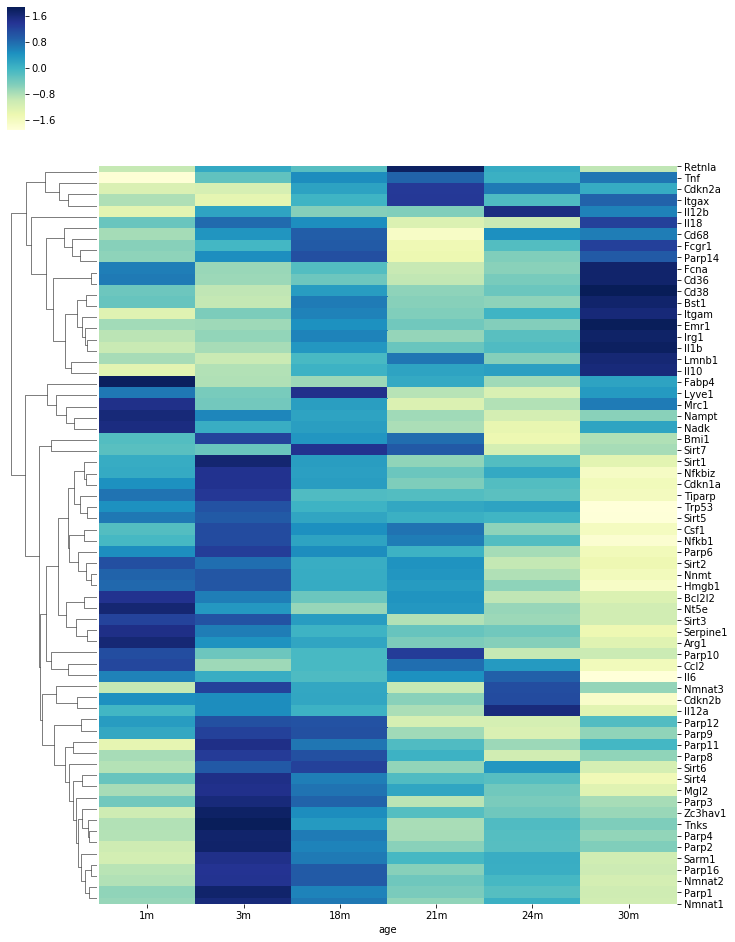

In [191]:
df = senescence_fractions.copy()
df = df.transpose()
# df = np.log(df)
# ax = sns.heatmap(df, cmap="YlGnBu")
sns.clustermap(df, cmap="YlGnBu", yticklabels=True,
               figsize=(12,(.25*(len(df.index)))),
#                standard_scale=0,
               col_cluster=False, 
               z_score=0
              )
plt.savefig('senescence_fractions.pdf')

In [194]:
348/1780

0.19550561797752808

ranking genes


/home/angela/anaconda3/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:380: RuntimeWarning: overflow encountered in expm1
  foldchanges = (np.expm1(means[imask]) + 1e-9) / (np.expm1(mean_rest) + 1e-9)  # add small value to remove 0's
/home/angela/anaconda3/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:380: RuntimeWarning: invalid value encountered in true_divide
  foldchanges = (np.expm1(means[imask]) + 1e-9) / (np.expm1(mean_rest) + 1e-9)  # add small value to remove 0's
/home/angela/anaconda3/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:380: RuntimeWarning: overflow encountered in expm1
  foldchanges = (np.expm1(means[imask]) + 1e-9) / (np.expm1(mean_rest) + 1e-9)  # add small value to remove 0's
/home/angela/anaconda3/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:380: RuntimeWarning: invalid value encountered in true_divide
  foldchanges = (np.expm1(means[imask]) + 1e-9) / (np.expm1(mean_rest) + 1e-9)  # add small va

/home/angela/anaconda3/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:380: RuntimeWarning: overflow encountered in expm1
  foldchanges = (np.expm1(means[imask]) + 1e-9) / (np.expm1(mean_rest) + 1e-9)  # add small value to remove 0's
/home/angela/anaconda3/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:380: RuntimeWarning: invalid value encountered in true_divide
  foldchanges = (np.expm1(means[imask]) + 1e-9) / (np.expm1(mean_rest) + 1e-9)  # add small value to remove 0's
/home/angela/anaconda3/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:387: RuntimeWarning: divide by zero encountered in log2
  rankings_gene_logfoldchanges.append(np.log2(foldchanges[global_indices]))
/home/angela/anaconda3/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:380: RuntimeWarning: overflow encountered in expm1
  foldchanges = (np.expm1(means[imask]) + 1e-9) / (np.expm1(mean_rest) + 1e-9)  # add small value to remove 0's
/home/angela/anaconda3/l

    finished (0:38:03.34) --> added to `.uns['rank_genes_groups_wilcox']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids


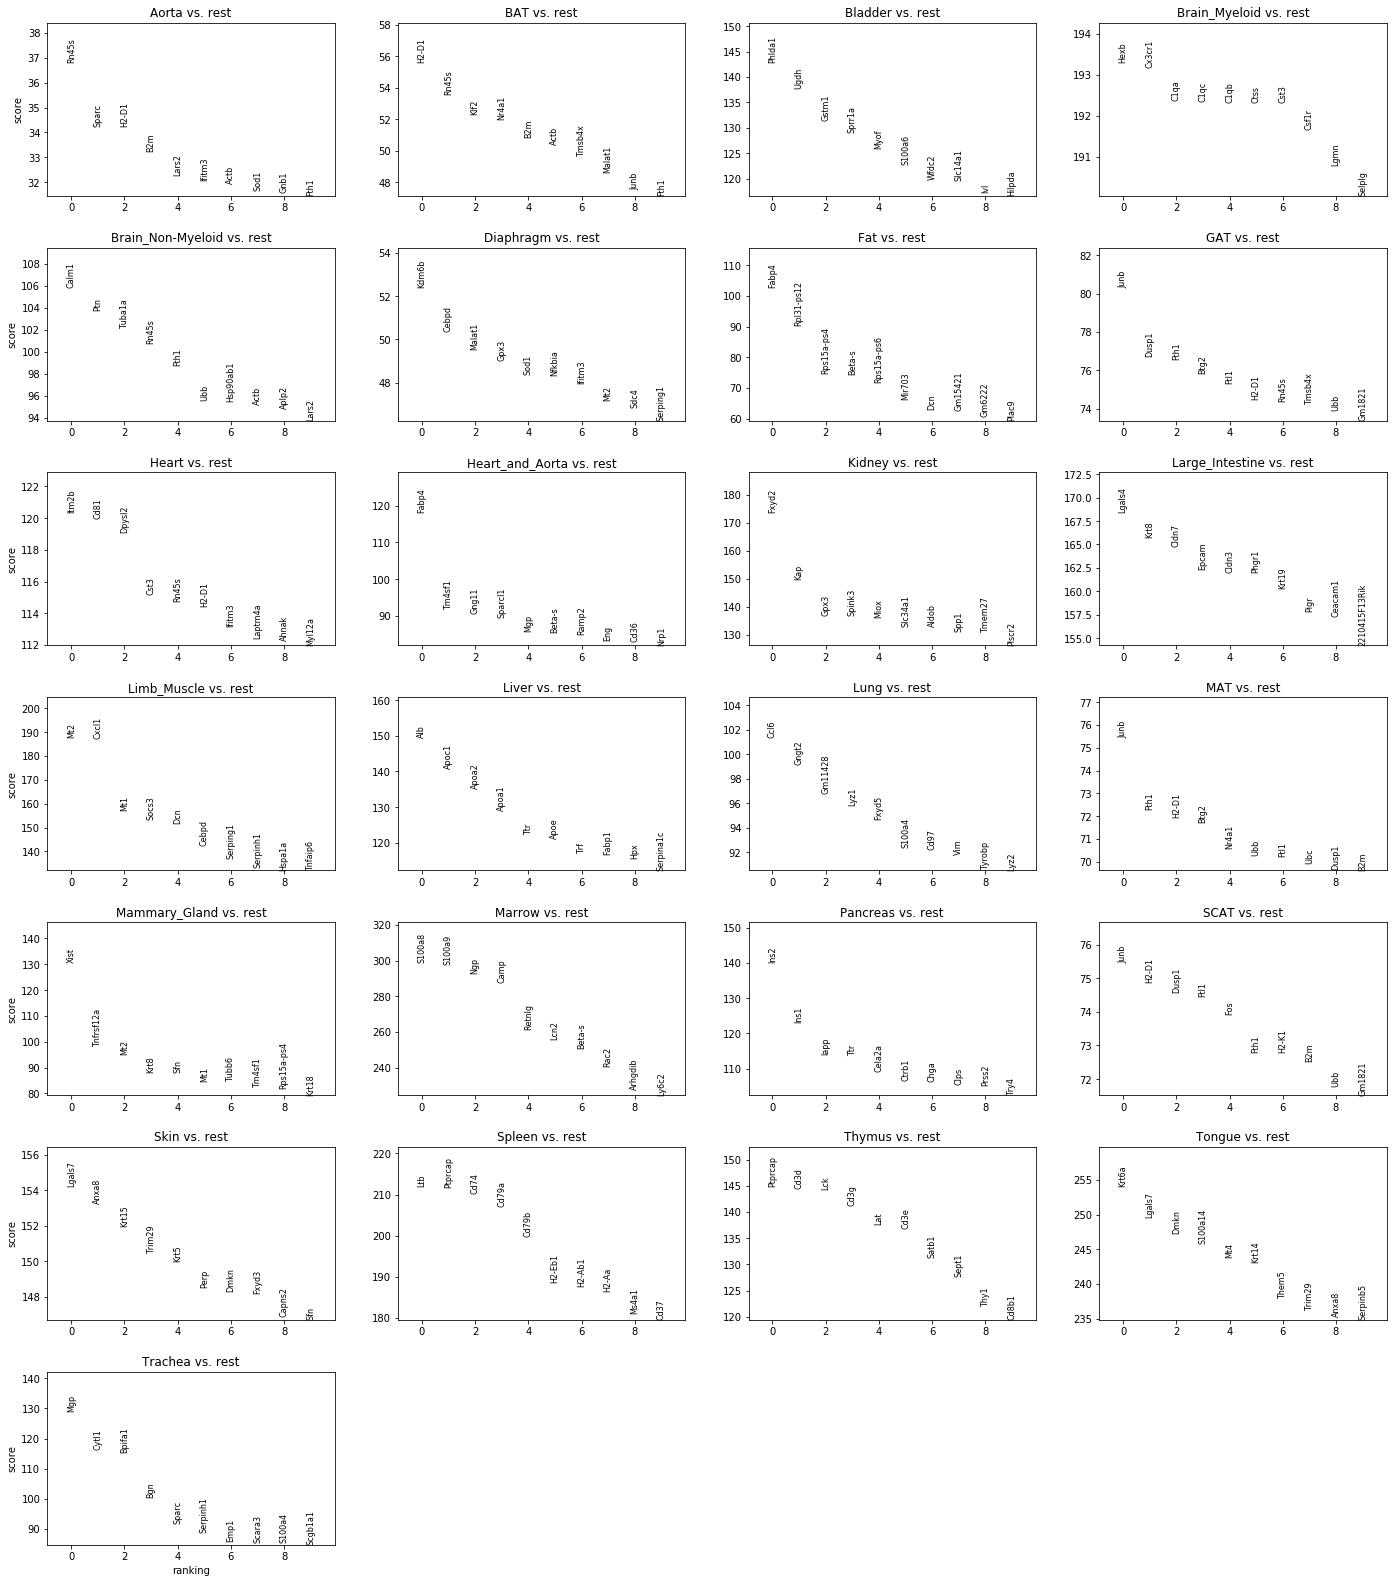

In [59]:
sc.tl.rank_genes_groups(
    adata,
    "tissue",
    method="wilcoxon",
    use_raw=False,
    key_added="rank_genes_groups_wilcox",
    n_genes=n_genes,
)

sc.pl.rank_genes_groups(
    adata, key="rank_genes_groups_wilcox", sharey=False, n_genes=n_genes)

In [61]:
for 

{'params': {'groupby': 'tissue',
  'reference': 'rest',
  'method': 'wilcoxon',
  'use_raw': False,
  'corr_method': 'benjamini-hochberg'},
 'scores': rec.array([(36.805714, 55.58487 , 142.81622, 193.29666, 105.858475, 52.40335 , 102.782326, 80.32646 , 120.365746, 118.198135, 173.77518, 168.42728, 187.84929, 149.58717 , 101.376724, 75.46148 , 130.87517 , 299.21393, 140.26834 , 75.47957 , 154.18417, 211.85538, 144.79495 , 253.98233, 128.92015 ),
            (34.245636, 53.580322, 137.71951, 193.17859, 103.7985  , 50.371387,  90.47592 , 76.74093 , 119.99034 ,  91.79842 , 149.68015, 165.74615, 187.34769, 140.79211 ,  99.17016 , 72.26872 ,  98.28891 , 297.9586 , 123.169426, 74.86139 , 153.23795, 211.61435, 144.52197 , 249.59795, 116.32902 ),
            (34.219055, 52.309917, 131.46078, 192.37354, 102.09886 , 49.54865 ,  74.83576 , 76.547035, 119.08879 ,  90.586624, 137.10951, 164.76602, 157.1439 , 135.14378 ,  96.7549  , 71.93267 ,  94.867355, 292.79468, 113.95158 , 74.56098 , 151.93709, 

In [63]:
result = adata.uns['rank_genes_groups_wilcox']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'scores']}).head(5)

,Aorta_n,Aorta_s,BAT_n,BAT_s,Bladder_n,Bladder_s,Brain_Myeloid_n,Brain_Myeloid_s,Brain_Non-Myeloid_n,Brain_Non-Myeloid_s,...,Skin_n,Skin_s,Spleen_n,Spleen_s,Thymus_n,Thymus_s,Tongue_n,Tongue_s,Trachea_n,Trachea_s
0,Rn45s,36.805714,H2-D1,55.584869,Phlda1,142.816223,Hexb,193.296661,Calm1,105.858475,...,Lgals7,154.184174,Ltb,211.855377,Ptprcap,144.794952,Krt6a,253.982330,Mgp,128.920151
1,Sparc,34.245636,Rn45s,53.580322,Ugdh,137.719513,Cx3cr1,193.178589,Ptn,103.798500,...,Anxa8,153.237946,Ptprcap,211.614349,Cd3d,144.521973,Lgals7,249.597946,Cytl1,116.329018
2,H2-D1,34.219055,Klf2,52.309917,Gstm1,131.460785,C1qa,192.373535,Tuba1a,102.098862,...,Krt15,151.937088,Cd74,210.275772,Lck,144.234863,Dmkn,247.267975,Bpifa1,115.245857
3,B2m,33.216743,Nr4a1,51.971672,Sprr1a,129.047073,C1qc,192.355453,Rn45s,100.718895,...,Trim29,150.446320,Cd79a,207.112549,Cd3g,141.172852,S100a14,245.750671,Bgn,100.574371
4,Lars2,32.246983,B2m,50.828629,Myof,125.983078,C1qb,192.332809,Fth1,98.753029,...,Krt5,149.989441,Cd79b,199.702209,Lat,137.556259,Mt4,243.788696,Sparc,91.912598


In [62]:
result = adata.uns['rank_genes_groups_scvi']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'scores']}).head(5)

,0_n,0_s,1_n,1_s,2_n,2_s,3_n,3_s,4_n,4_s,...,20_n,20_s,21_n,21_s,22_n,22_s,23_n,23_s,24_n,24_s
0,G630055G22RIK,2.081581,KLF2,1.363944,MYOF,3.307934,HEXB,5.234733,MBP,3.813225,...,AADACL3,5.313606,LTB,2.519535,LCK,2.944439,THEM5,5.710525,GM15698,2.646582
1,RGS5,2.005755,OASL1,1.272673,1110059M19RIK,3.119747,P2RY12,5.093346,ZIC3,3.476098,...,9130204L05RIK,5.126884,DEFB6,2.372422,SIT1,2.838094,LYG1,5.595713,CYTL1,2.522439
2,FABP4,1.986760,CREM,1.266249,NPY5R,2.972150,4930556J02RIK,4.783164,GPR37L1,3.122219,...,CALM5,5.029430,FFAR1,2.271630,SKAP1,2.794907,OTOP2,5.399166,1700016G22RIK,2.416807
3,ZFP366,1.974559,SLC24A1,1.217935,LOC627800,2.955015,LGMN,4.783164,S100B,3.050405,...,SERPINA3H,5.014062,PTPRCAP,2.265744,CD8A,2.783907,PAX9,5.293303,5930438M14,2.414150
4,UNC45B,1.966178,ISG15,1.182517,GSTM1,2.946546,LPCAT2,4.701489,2610017I09RIK,3.043475,...,CCL27A,4.820281,GIMAP7,2.259887,LAT,2.742704,PITX1,5.179371,LIF,2.394409
